# Рекуррентные нейронные сети RNN LSTM GRU

In [1]:
!pip install pymorphy2

     |████████████████████████████████| 55 kB 3.1 MB/s 
     |████████████████████████████████| 8.2 MB 11.3 MB/s 


In [2]:
!pip install stop-words

  Created wheel for stop-words: filename=stop_words-2018.7.23-py3-none-any.whl size=32911 sha256=f00fa637183fedb1fc7565de886c67af115e31e56c3484603a966dec1c5a3b3c
  Stored in directory: /root/.cache/pip/wheels/fb/86/b2/277b10b1ce9f73ce15059bf6975d4547cc4ec3feeb651978e9
Successfully built stop-words


In [3]:
# попробуем запрограммировать простую рекурентную сеть. Возьмем датасет с прошлого занятия

import pandas as pd
from string import punctuation
from stop_words import get_stop_words
from pymorphy2 import MorphAnalyzer
import re

In [4]:
df_train = pd.read_csv("../content/drive/MyDrive/data/train.csv")
df_test = pd.read_csv("../content/drive/MyDrive/data/test.csv")
df_val = pd.read_csv("../content/drive/MyDrive/data/val.csv")

In [5]:
df_train.head()

,id,text,class
0,0,@alisachachka не уезжаааааааай. :(❤ я тоже не ...,0
1,1,RT @GalyginVadim: Ребята и девчата!\nВсе в кин...,1
2,2,RT @ARTEM_KLYUSHIN: Кто ненавидит пробки ретви...,0
3,3,RT @epupybobv: Хочется котлету по-киевски. Зап...,1
4,4,@KarineKurganova @Yess__Boss босапопа есбоса н...,1


In [6]:
sw = set(get_stop_words("ru"))
exclude = set(punctuation)
morpher = MorphAnalyzer()

def preprocess_text(txt):
    txt = str(txt)
    txt = "".join(c for c in txt if c not in exclude)
    txt = txt.lower()
    txt = re.sub("\sне", "не", txt)
    txt = [morpher.parse(word)[0].normal_form for word in txt.split() if word not in sw]
    return " ".join(txt)

df_train['text'] = df_train['text'].apply(preprocess_text)
df_val['text'] = df_val['text'].apply(preprocess_text)
df_test['text'] = df_test['text'].apply(preprocess_text)

In [8]:
import matplotlib.pyplot as plt
import tensorflow as tf

import numpy as np
#import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Input, Embedding, Conv1D, GlobalMaxPool1D, concatenate, Flatten, add, MaxPool1D
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Masking, Bidirectional, GlobalAveragePooling1D, GlobalMaxPooling1D, TimeDistributed, AveragePooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import TensorBoard 
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.callbacks import EarlyStopping

In [9]:
text_corpus_train = df_train['text'].values
text_corpus_valid = df_val['text'].values
text_corpus_test = df_test['text'].values

In [10]:
tokenizer = Tokenizer(num_words=None, 
                     filters='#$%&()*+-<=>@[\\]^_`{|}~\t\n',
                     lower = False, split = ' ')
tokenizer.fit_on_texts(text_corpus_train)

sequences_train = tokenizer.texts_to_sequences(text_corpus_train)
sequences_val = tokenizer.texts_to_sequences(text_corpus_valid)
sequences_test = tokenizer.texts_to_sequences(text_corpus_test)

word_count = len(tokenizer.index_word) + 1
training_length = max([len(i.split()) for i in text_corpus_train])

X_train = pad_sequences(sequences_train, maxlen=training_length)
X_valid = pad_sequences(sequences_val, maxlen=training_length)

In [11]:
y_train = df_train['class'].values
y_val = df_val['class'].values

In [12]:
def plot_history(history):
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
       
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_title('model accuracy')
    ax1.set(xlabel='epoch', ylabel='accuracy')
    ax1.legend(['train', 'test'], loc='upper left')
    
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('model loss')
    ax2.set(xlabel='epoch', ylabel='loss')
    ax2.legend(['train', 'test'], loc='upper left')

## CNN

In [13]:
inputs = Input(shape=(X_train.shape[1],))

x =     Embedding(input_dim=word_count,
              input_length=training_length,
              output_dim=30,
              trainable=True,
              mask_zero=True)(inputs)

x = Conv1D(128, 3, activation='relu')(x)

x = GlobalMaxPool1D()(x)
#x = Flatten()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)



model = Model(inputs=inputs, outputs=x)
model.summary()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 27)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 27, 30)            7743240   
_________________________________________________________________
conv1d (Conv1D)              (None, 25, 128)           11648     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65    

Epoch 1/25
709/709 [==============================] - 85s 75ms/step - loss: 0.5403 - accuracy: 0.7166 - val_loss: 0.5105 - val_accuracy: 0.7463
Epoch 2/25
709/709 [==============================] - 54s 76ms/step - loss: 0.2906 - accuracy: 0.8817 - val_loss: 0.5842 - val_accuracy: 0.7405
Epoch 3/25
709/709 [==============================] - 53s 75ms/step - loss: 0.1053 - accuracy: 0.9631 - val_loss: 0.7976 - val_accuracy: 0.7276
Epoch 4/25
709/709 [==============================] - 52s 74ms/step - loss: 0.0441 - accuracy: 0.9858 - val_loss: 0.9761 - val_accuracy: 0.7209


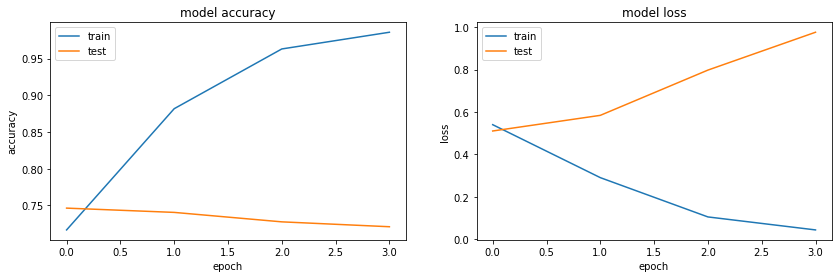

In [14]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

history = model.fit(X_train, y_train, batch_size=128*2, epochs=25, 
          validation_data=(X_valid, y_val), callbacks=[callback], verbose=1)
plot_history(history)

In [15]:
model.evaluate(X_valid, y_val)

709/709 [==============================] - 1s 2ms/step - loss: 0.5046 - accuracy: 0.7473


[0.5045841336250305, 0.7472556829452515]

## SimpleRNN

In [15]:
inputs = Input(shape=(X_train.shape[1],))

x =     Embedding(input_dim=word_count,
              input_length=training_length,
              output_dim=30,
              trainable=True,
              mask_zero=True)(inputs)

x = SimpleRNN(64)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(inputs=inputs, outputs=x)
model.summary()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 27)]              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 27, 30)            7743240   
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 64)                6080      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 7,753,545
Trainable params: 7,753,545
Non-trainable params: 0
_________________________________________________

Epoch 1/25
709/709 [==============================] - 77s 107ms/step - loss: 0.5357 - accuracy: 0.7208 - val_loss: 0.5012 - val_accuracy: 0.7467
Epoch 2/25
709/709 [==============================] - 77s 109ms/step - loss: 0.2553 - accuracy: 0.8965 - val_loss: 0.5990 - val_accuracy: 0.7285
Epoch 3/25
709/709 [==============================] - 77s 108ms/step - loss: 0.0760 - accuracy: 0.9726 - val_loss: 0.8203 - val_accuracy: 0.7252
Epoch 4/25
709/709 [==============================] - 76s 108ms/step - loss: 0.0332 - accuracy: 0.9884 - val_loss: 1.1346 - val_accuracy: 0.7154


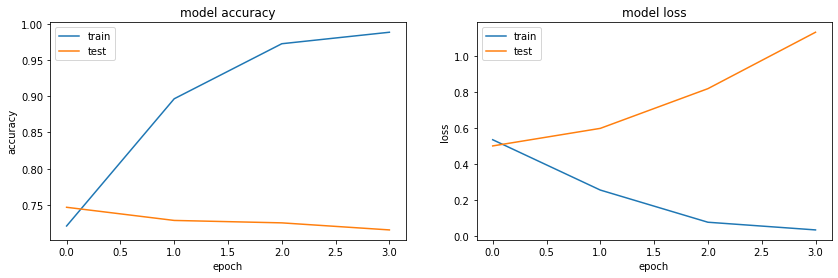

In [16]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

history = model.fit(X_train, y_train, batch_size=128*2, epochs=25, 
          validation_data=(X_valid, y_val), callbacks=[callback], verbose=1)
plot_history(history)

In [17]:
model.evaluate(X_valid, y_val)

709/709 [==============================] - 3s 5ms/step - loss: 0.5012 - accuracy: 0.7467


[0.5011664032936096, 0.7466825246810913]

## LSTM

In [18]:
inputs = Input(shape=(X_train.shape[1],))

x =     Embedding(input_dim=word_count,
              input_length=training_length,
              output_dim=30,
              trainable=True,
              mask_zero=True)(inputs)

x = LSTM(64, return_sequences=True)(x)

x = Flatten()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)



model = Model(inputs=inputs, outputs=x)
model.summary()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 27)]              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 27, 30)            7743240   
_________________________________________________________________
lstm (LSTM)                  (None, 27, 64)            24320     
_________________________________________________________________
flatten (Flatten)            (None, 1728)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                110656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65  

Epoch 1/25
709/709 [==============================] - 106s 145ms/step - loss: 0.5299 - accuracy: 0.7273 - val_loss: 0.5021 - val_accuracy: 0.7473
Epoch 2/25
709/709 [==============================] - 104s 146ms/step - loss: 0.2867 - accuracy: 0.8820 - val_loss: 0.5652 - val_accuracy: 0.7391
Epoch 3/25
709/709 [==============================] - 102s 144ms/step - loss: 0.1303 - accuracy: 0.9509 - val_loss: 0.7989 - val_accuracy: 0.7302
Epoch 4/25
709/709 [==============================] - 102s 144ms/step - loss: 0.0729 - accuracy: 0.9732 - val_loss: 1.0467 - val_accuracy: 0.7211


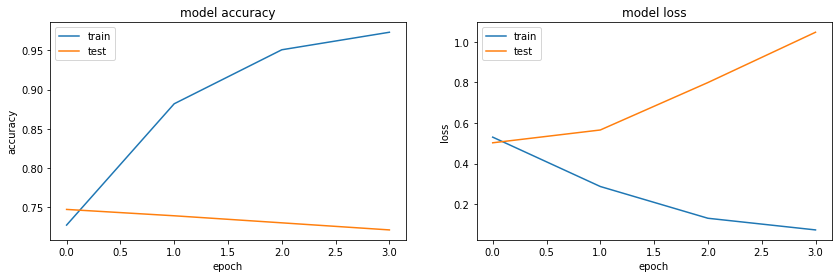

In [19]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

history = model.fit(X_train, y_train, batch_size=128*2, epochs=25, 
          validation_data=(X_valid, y_val), callbacks=[callback], verbose=1)
plot_history(history)

In [20]:
model.evaluate(X_valid, y_val)

709/709 [==============================] - 5s 7ms/step - loss: 0.5021 - accuracy: 0.7473


[0.5020561814308167, 0.7472556829452515]

## ConvLSTM2D

In [21]:
inputs = Input(shape=(X_train.shape[1],))

x =     Embedding(input_dim=word_count,
              input_length=training_length,
              output_dim=30,
              trainable=True,
              mask_zero=True)(inputs)


x = tf.keras.layers.Reshape((27, 30, 1, 1))(x)
x = tf.keras.layers.ConvLSTM2D(filters=64, kernel_size=(1,2), activation='relu', padding="same")(x)


x = Flatten()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)



model = Model(inputs=inputs, outputs=x)
model.summary()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 27)]              0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 27, 30)            7743240   
_________________________________________________________________
reshape (Reshape)            (None, 27, 30, 1, 1)      0         
_________________________________________________________________
conv_lst_m2d (ConvLSTM2D)    (None, 30, 1, 64)         33536     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1920)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                122944    
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0   

Epoch 1/25
709/709 [==============================] - 184s 255ms/step - loss: 0.5548 - accuracy: 0.7072 - val_loss: 0.5093 - val_accuracy: 0.7441
Epoch 2/25
709/709 [==============================] - 180s 253ms/step - loss: 0.3415 - accuracy: 0.8599 - val_loss: 0.5592 - val_accuracy: 0.7349
Epoch 3/25
709/709 [==============================] - 179s 252ms/step - loss: 0.1730 - accuracy: 0.9365 - val_loss: 0.7610 - val_accuracy: 0.7298
Epoch 4/25
709/709 [==============================] - 178s 251ms/step - loss: 0.0973 - accuracy: 0.9653 - val_loss: 1.0386 - val_accuracy: 0.7194


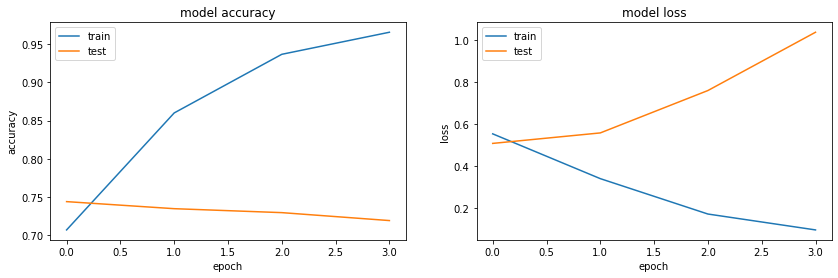

In [22]:
history = model.fit(X_train, y_train, batch_size=128*2, epochs=25, 
          validation_data=(X_valid, y_val), callbacks=[callback], verbose=1)
plot_history(history)

In [23]:
model.evaluate(X_valid, y_val)

709/709 [==============================] - 16s 23ms/step - loss: 0.5093 - accuracy: 0.7441


[0.5092853903770447, 0.7441255450248718]

## CNN+LSTM

In [24]:
inputs = Input(shape=(X_train.shape[1],))

x =     Embedding(input_dim=word_count,
              input_length=training_length,
              output_dim=30,
              trainable=True,
              mask_zero=True)(inputs)

x = (Conv1D(filters=64, kernel_size=3, activation='relu', padding="same"))(x)

x = LSTM(64, return_sequences=True)(x)

x = Flatten()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)



model = Model(inputs=inputs, outputs=x)
model.summary()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 27)]              0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 27, 30)            7743240   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 27, 64)            5824      
_________________________________________________________________
lstm_1 (LSTM)                (None, 27, 64)            33024     
_________________________________________________________________
flatten_2 (Flatten)          (None, 1728)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)                110656    
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0   

Epoch 1/25
709/709 [==============================] - 56s 76ms/step - loss: 0.5330 - accuracy: 0.7237 - val_loss: 0.5275 - val_accuracy: 0.7434
Epoch 2/25
709/709 [==============================] - 53s 74ms/step - loss: 0.2696 - accuracy: 0.8902 - val_loss: 0.5938 - val_accuracy: 0.7406
Epoch 3/25
709/709 [==============================] - 52s 74ms/step - loss: 0.1040 - accuracy: 0.9620 - val_loss: 0.8397 - val_accuracy: 0.7337
Epoch 4/25
709/709 [==============================] - 53s 74ms/step - loss: 0.0500 - accuracy: 0.9822 - val_loss: 1.0182 - val_accuracy: 0.7275


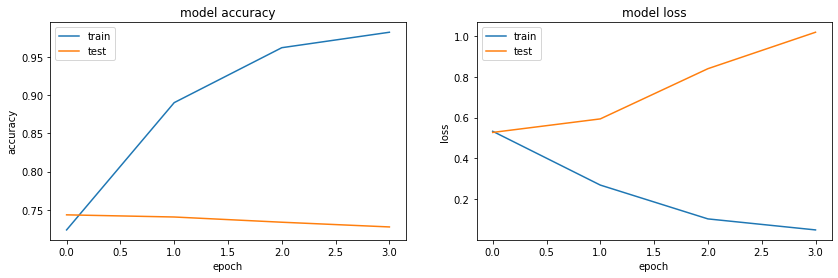

In [25]:
history = model.fit(X_train, y_train, batch_size=128*2, epochs=25, 
          validation_data=(X_valid, y_val), callbacks=[callback], verbose=1)
plot_history(history)

In [26]:
model.evaluate(X_valid, y_val)

709/709 [==============================] - 2s 3ms/step - loss: 0.5275 - accuracy: 0.7434


[0.5274951457977295, 0.7433760762214661]

## LSTM + CNN

In [27]:
inputs = Input(shape=(X_train.shape[1],))

x =     Embedding(input_dim=word_count,
              input_length=training_length,
              output_dim=30,
              trainable=True,
              mask_zero=True)(inputs)


x = LSTM(64, return_sequences=True)(x)
x = (Conv1D(filters=64, kernel_size=3, activation='relu', padding="same"))(x)

x = Flatten()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)



model = Model(inputs=inputs, outputs=x)
model.summary()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 27)]              0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 27, 30)            7743240   
_________________________________________________________________
lstm_2 (LSTM)                (None, 27, 64)            24320     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 27, 64)            12352     
_________________________________________________________________
flatten_3 (Flatten)          (None, 1728)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)                110656    
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0   

Epoch 1/25
709/709 [==============================] - 106s 144ms/step - loss: 0.5330 - accuracy: 0.7247 - val_loss: 0.5075 - val_accuracy: 0.7449
Epoch 2/25
709/709 [==============================] - 101s 143ms/step - loss: 0.2852 - accuracy: 0.8823 - val_loss: 0.6171 - val_accuracy: 0.7373
Epoch 3/25
709/709 [==============================] - 101s 142ms/step - loss: 0.1314 - accuracy: 0.9516 - val_loss: 0.8237 - val_accuracy: 0.7295
Epoch 4/25
709/709 [==============================] - 102s 143ms/step - loss: 0.0732 - accuracy: 0.9735 - val_loss: 1.0900 - val_accuracy: 0.7224


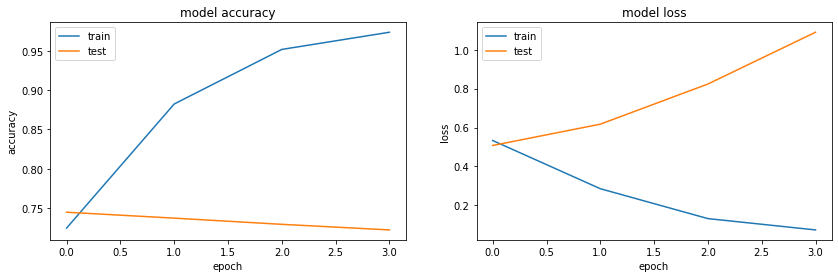

In [28]:
history = model.fit(X_train, y_train, batch_size=128*2, epochs=25, 
          validation_data=(X_valid, y_val), callbacks=[callback], verbose=1)
plot_history(history)

In [29]:
model.evaluate(X_valid, y_val)

709/709 [==============================] - 5s 7ms/step - loss: 0.5075 - accuracy: 0.7449


[0.5074930787086487, 0.7448750138282776]

### Выводы.
Лучше всего сработали (в порядке убывания результата) следующие архитектуры:

1. LSTM 
2. CNN 
3. SimpleRNN

При этом их результаты не сильно отличаются и однозначно сказать что какая то архитектура лучше других нельзя.